In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)
    
from src.data.datasets import FreeViewInMemory
from src.data.transforms import AddRandomCenterCorrelatedRadialNoise, SaveCleanX

In [8]:
noise = AddRandomCenterCorrelatedRadialNoise(
    initial_center = [320//2,512//2],
    ptoa = 1/16,
    radial_corr = 0.5,
    radial_avg_norm = 4.13,
    radial_std = 5.5,
    center_noise_std = 50,
    center_corr = 0.9,
    center_delta_norm = 200,
    center_delta_r = 0.2,
)

save = SaveCleanX()

In [9]:
data = FreeViewInMemory(transforms=[save,noise])

In [13]:
idx = np.random.randint(0,len(data),1)
item = data[idx[0]]

In [15]:
x = item['x']
clean_x = item['clean_x']

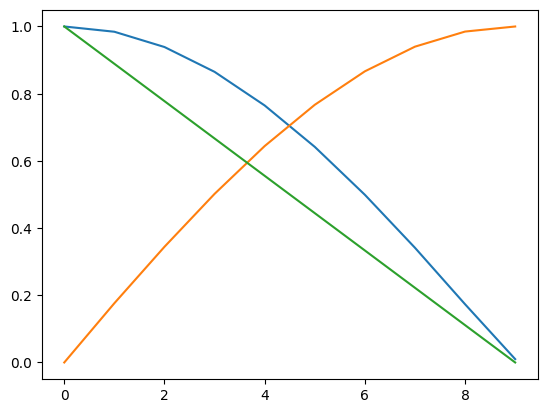

In [63]:
import math
def get_cosine_schedule_alphas_bar(num_steps, s=0.008):
    steps = np.linspace(0, num_steps, num_steps)
    
    # The cosine function ensures a smooth decay to zero
    f_t = np.cos(((steps / num_steps) + s) / (1 + s) * (math.pi / 2)) ** 2
    alphas_cumprod = f_t / f_t[0]
    
    # Ensure it doesn't hit absolute zero too fast for stability
    return np.clip(alphas_cumprod, a_min=0.0001, a_max=None)
cum_alpha = get_cosine_schedule_alphas_bar(10, s = 0.002)
plt.plot(np.sqrt(cum_alpha))
plt.plot(np.sqrt(1 - cum_alpha))
plt.plot(1 - np.linspace(0,1,10))

In [65]:
curriculum = clean_coords[np.newaxis,:,:]*np.sqrt(cum_alpha)[:,np.newaxis,np.newaxis] + noise[np.newaxis,:,:]*np.sqrt(1 - cum_alpha)[:,np.newaxis,np.newaxis]

In [67]:
curriculum.shape

(10, 2, 23)

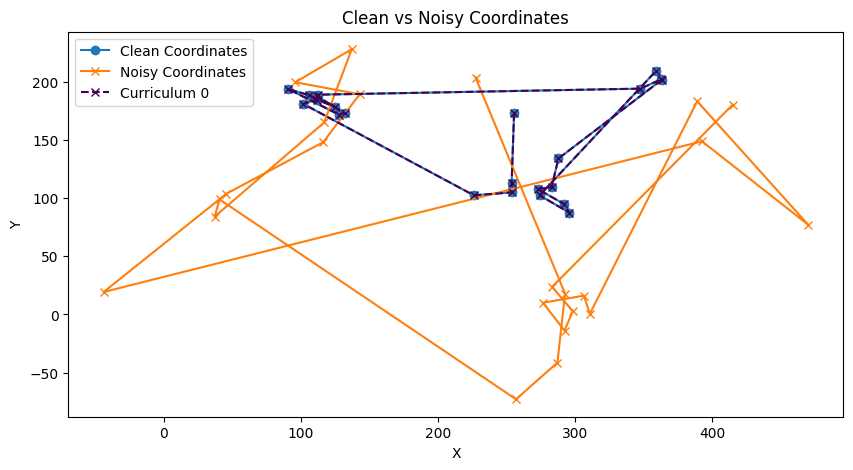

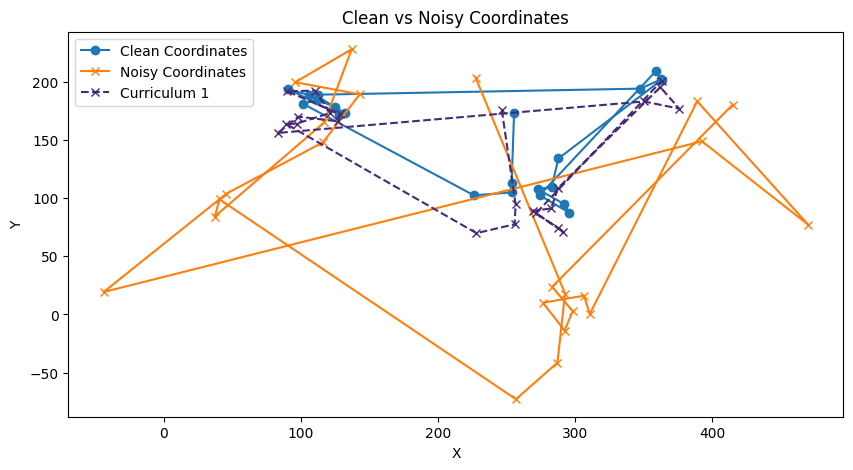

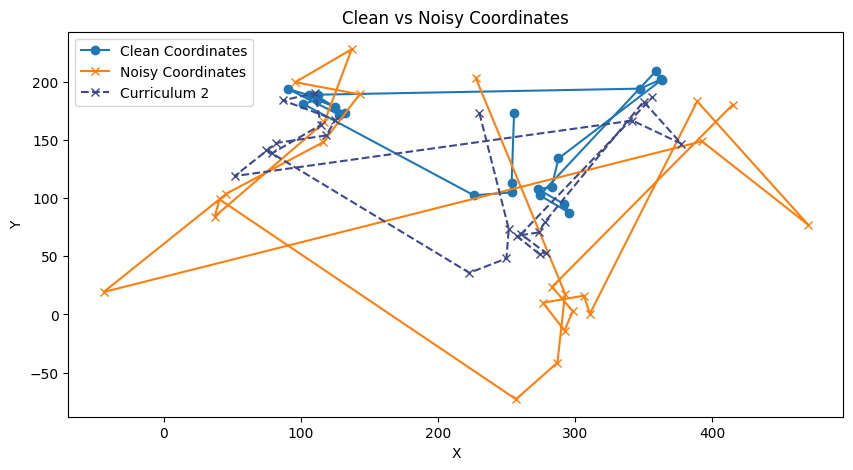

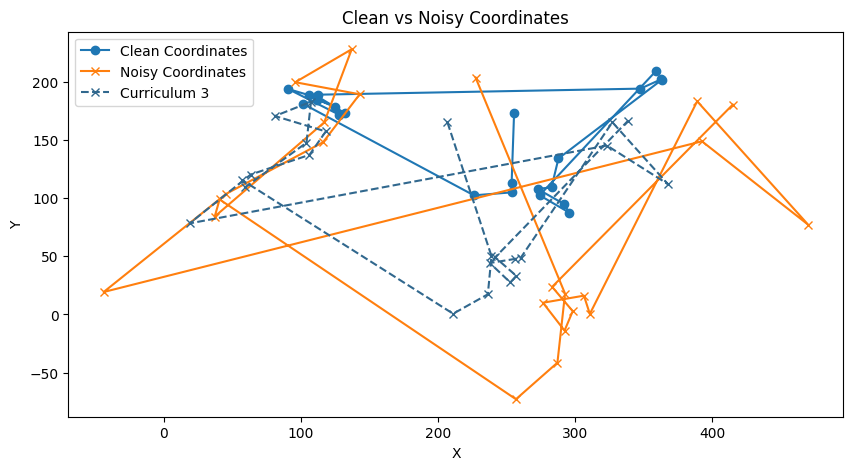

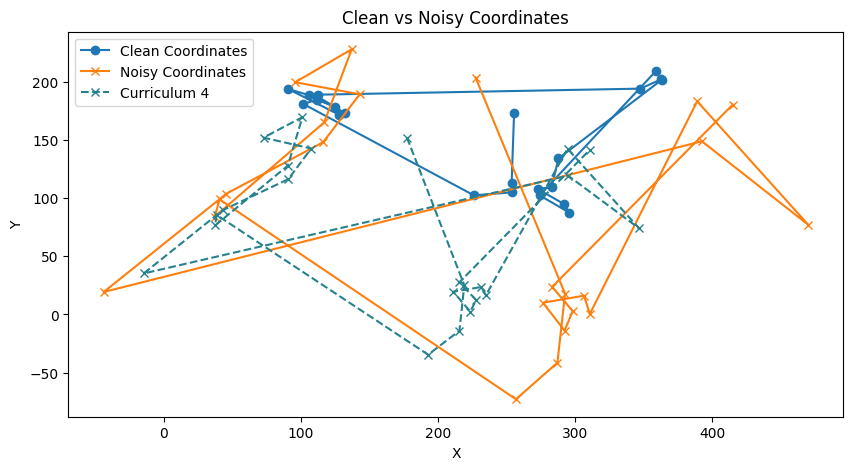

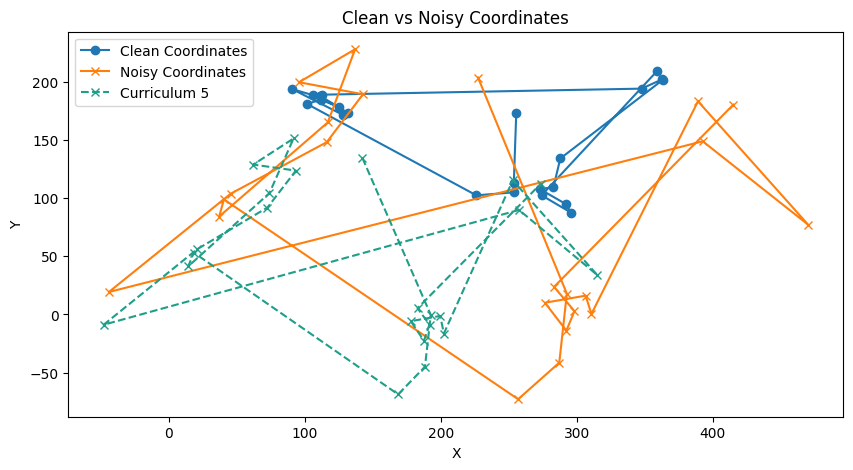

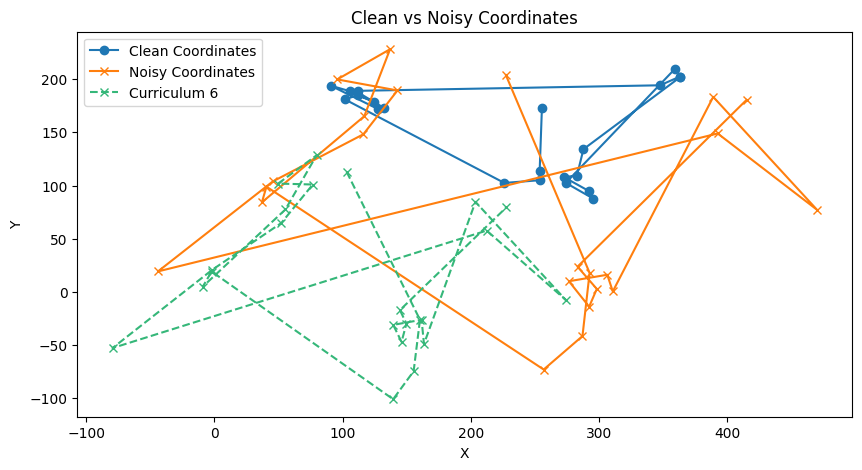

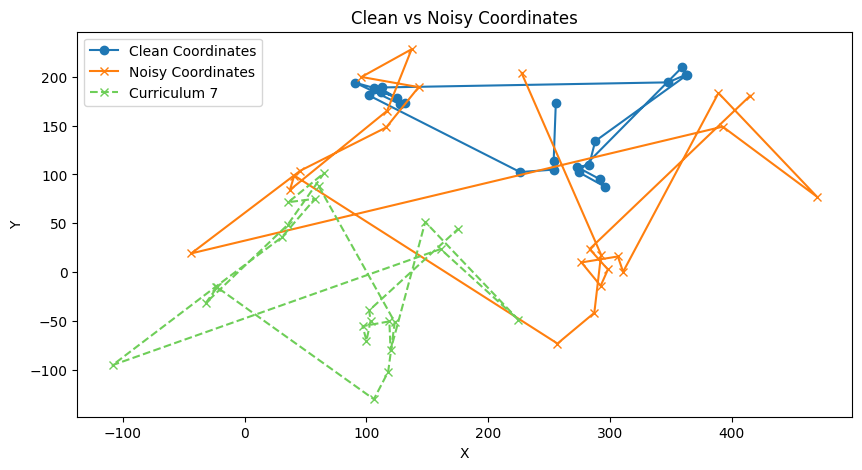

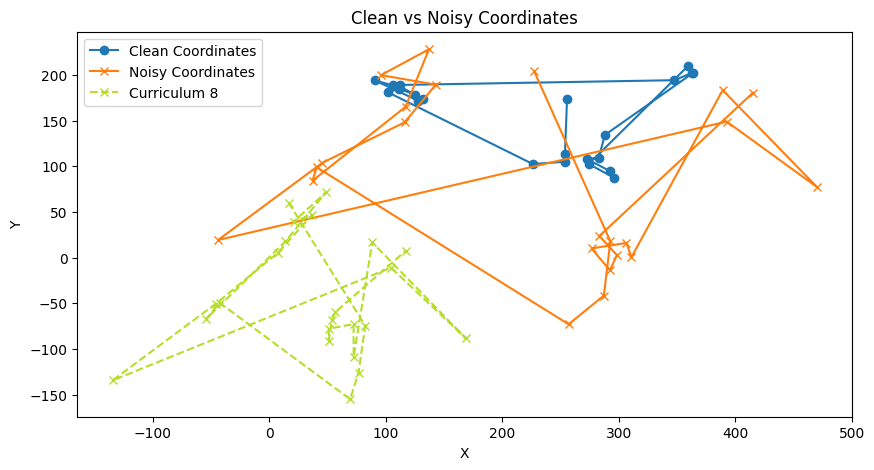

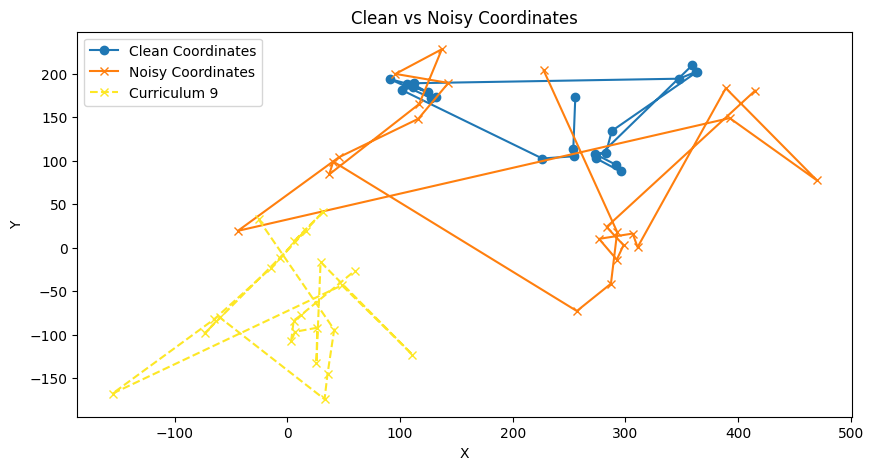

In [72]:
# shape (coords, items)
import matplotlib.cm as cm
import matplotlib.colors as mcolors
coords = x[:2]
clean_coords = clean_x[:2]
noise = coords - clean_coords
for i in range(N):
    plt.figure(figsize=(10, 5))
    plt.plot(clean_coords[0], clean_coords[1], label='Clean Coordinates', marker='o')
    plt.plot(coords[0], coords[1], label='Noisy Coordinates', marker='x')

    # Color progression for curriculum steps

    N = curriculum.shape[0]
    colors = cm.viridis(np.linspace(0, 1, N))
    plt.plot(curriculum[i,0], curriculum[i,1], color=colors[i], marker='x', linestyle='--', label=f'Curriculum {i}')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Clean vs Noisy Coordinates')
    plt.legend()
    plt.show()